In [80]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from T01_prototype.S00_utils import loadPickle, plot_res, store_results
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [82]:
from T02_fusion_transformer.S02_attn.models import MyModel_Attn as MyModel

In [83]:
df = pd.read_excel("../T01_prototype/output/S21__2025-04-21-052727.xlsx")
df = df.set_index("Unnamed: 0")
df.index.names = ["id"]
df.head()

,m1,m2,m3,s1__autocorrelation__lag_8,s1__autocorrelation__lag_9,s1__autocorrelation__lag_7,s1__autocorrelation__lag_6,s1__autocorrelation__lag_5,s1__autocorrelation__lag_4,s1__longest_strike_above_mean,...,s1__ar_coefficient__coeff_3__k_10,s1__approximate_entropy__m_2__r_0.1,s1__lempel_ziv_complexity__bins_3,s1__partial_autocorrelation__lag_4,"s1__fft_coefficient__attr_""abs""__coeff_7","s1__agg_autocorrelation__f_agg_""var""__maxlag_40",s1__spkt_welch_density__coeff_2,y1,y2,y3
id,,,,,,,,,,,,,,,,,,,,,
E001,150.223716,1176.177278,1.142097,-0.305434,-0.519191,-0.074829,0.159896,0.385790,0.590387,14,...,0.183996,0.158567,0.204152,-0.360084,0.293617,0.499488,5.886812e-08,55.460434,1.065917,114.578620
E002,102.534268,1483.654982,1.104716,-0.243785,-0.454262,-0.021002,0.202836,0.416423,0.608972,14,...,0.184370,0.144742,0.203008,-0.344364,6.142373,0.477743,3.643621e-06,50.640306,1.285666,124.651484
E003,119.890549,1254.897451,2.162773,-0.329006,-0.543405,-0.095913,0.142612,0.373002,0.582151,14,...,0.184036,0.144268,0.208163,-0.364611,26.783283,0.506435,1.590028e-04,50.832405,1.154859,57.018054
E004,162.830799,1302.043195,1.308283,-0.065152,-0.266498,0.138913,0.337187,0.521401,0.683873,16,...,0.187213,0.137326,0.193662,-0.355441,33.227591,0.460547,7.926165e-04,62.476545,1.025161,132.221218
E005,165.720956,1154.482314,1.566830,-0.304881,-0.518177,-0.074836,0.159321,0.384728,0.589003,14,...,0.183978,0.128546,0.192440,-0.357588,11.439470,0.497940,1.462831e-04,57.634438,1.043776,92.160269


In [84]:
colsY = ["y1", "y2", "y3"]
# colsX = [c for c in df.columns if c not in colsY]
colsX = ["m1", "m2", "m3"]

dfX = df[colsX]
dfY = df[colsY]

In [85]:
dfData = loadPickle("../T01_prototype/output/S11__2025-04-21-052441.pickle")

In [86]:
dfData
tsArr = [t[1] for t in dfData["ts"].values]

In [87]:
# Max length
maxTime = 0
for ts in tsArr:
    maxTime = len(ts) if maxTime < len(ts) else maxTime

print(maxTime)

298


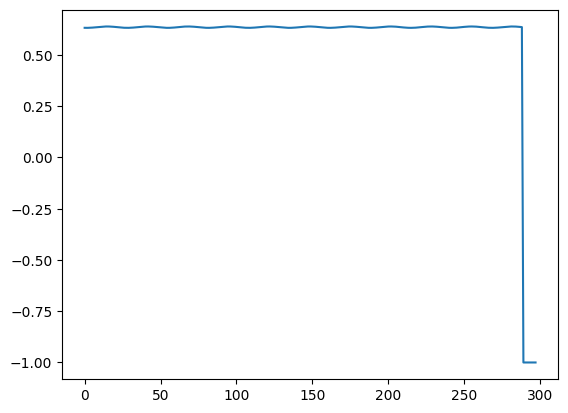

In [88]:
# Scaling and Padding
# TODO: Needs to only calculate mean, std, min, max from training example.

SCALING_TYPE = "Min_Max"
# SCALING_TYPE = "STANDARDIZATION"

tsArrConcat = np.concatenate(tsArr)
if SCALING_TYPE == "STANDARDIZATION":
    meanVal = np.mean(tsArrConcat)
    stdVal = np.std(tsArrConcat)
elif SCALING_TYPE == "Min_Max":
    maxVal = np.max(tsArrConcat)
    minVal = np.min(tsArrConcat)

# Shape = (Batch, Time, Features)
TsData_std = np.zeros((dfData.shape[0], maxTime, 1))
for idx, ts in enumerate(tsArr):
    if SCALING_TYPE == "STANDARDIZATION":
        ts_std = (ts - meanVal) / stdVal
    elif SCALING_TYPE == "Min_Max":
        ts_std = (ts - minVal) / (maxVal - minVal)

    TsData_std[idx, : len(ts), 0] = ts_std  # Scaling
    TsData_std[idx, len(ts) :, 0] = -1  # Padding

plt.plot(TsData_std[0, :])

In [89]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(random_state=0, test_size=0.30)
idxs = np.arange(df.shape[0])
idxTrain, idxTest = next(cv.split(X=idxs))
print(idxTrain)
print(idxTest)

[60 80 90 68 51 27 18 56 63 74  1 61 42 41  4 15 17 40 38  5 91 59  0 34
 28 50 11 35 23 52 10 31 66 57 79 85 32 84 14 89 19 29 49 97 98 69 20 94
 72 77 25 37 81 46 39 65 58 12 88 70 87 36 21 83  9 96 67 64 47 44]
[26 86  2 55 75 93 16 73 54 95 53 92 78 13  7 30 22 24 33  8 43 62  3 71
 45 48  6 99 82 76]


In [90]:
dfX_train = dfX.iloc[idxTrain, :]
dfX_test = dfX.iloc[idxTest, :]
dfY_train = dfY.iloc[idxTrain, :]
dfY_test = dfY.iloc[idxTest, :]
Ts_train_std = TsData_std[idxTrain, :]
Ts_test_std = TsData_std[idxTest, :]

In [91]:
scX = MinMaxScaler()
X_train_std = scX.fit_transform(dfX_train)
X_test_std = scX.transform(dfX_test)

scY = MinMaxScaler()
Y_train_std = scY.fit_transform(dfY_train)
Y_test_std = scY.transform(dfY_test)

In [92]:
# Convert to 2D PyTorch tensors
X_train_std = torch.tensor(X_train_std, dtype=torch.float32)
Y_train_std = torch.tensor(Y_train_std, dtype=torch.float32)
X_test_std = torch.tensor(X_test_std, dtype=torch.float32)
Y_test_std = torch.tensor(Y_test_std, dtype=torch.float32)
Ts_train_std = torch.tensor(Ts_train_std, dtype=torch.float32)
Ts_test_std = torch.tensor(Ts_test_std, dtype=torch.float32)

In [93]:
tab_num_features = dfX.shape[1]
ts_embedding_size = 16
ts_num_features = Ts_train_std.shape[-1]
lstm_num_layers = 2
lstm_dropout = 0.5
attn_n_head = 4
num_output = Y_test_std.shape[1]

# Initialize model
model = MyModel(
    tab_num_features=tab_num_features,
    ts_embedding_size=ts_embedding_size,
    ts_num_features=ts_num_features,
    lstm_num_layers=lstm_num_layers,
    lstm_dropout=lstm_dropout,
    attn_n_head=attn_n_head,
    num_output=num_output,
)

In [94]:
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
def get_seeder(batch_size, num_output):
    x_seeder = torch.zeros((batch_size, num_output, 1), dtype=torch.float)
    for i in range(0, num_output):
        x_seeder[:, i, 0] = float(i)
    return x_seeder

In [96]:
n_epochs = 100
# number of epochs to run
batch_size = 5  # size of each batch
batch_start = torch.arange(0, len(X_train_std), batch_size)

# Hold the best model
best_mse = np.inf  # init to infinity
best_weights = None
history = []

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            x_tab_batch = X_train_std[start : start + batch_size]
            x_ts_batch = Ts_train_std[start : start + batch_size]
            y_batch = Y_train_std[start : start + batch_size]
            # forward pass
            y_pred, _ = model(
                x_tab=x_tab_batch,
                x_ts=x_ts_batch,
                x_future=get_seeder(x_tab_batch.shape[0], num_output),
            )
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred, _ = model(
        x_ts=Ts_test_std,
        x_tab=X_test_std,
        x_seeder=get_seeder(Ts_test_std.shape[0], num_output),
    )
    mse = loss_fn(y_pred, Y_test_std)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

RuntimeError: shape '[5, 80]' is invalid for input of size 240

In [ ]:
Y_train_pred, attn_train = model(
    x_ts=Ts_train_std,
    x_tab=X_train_std,
    x_seeder=get_seeder(Ts_train_std.shape[0], num_output),
)
Y_test_pred, attn_test = model(
    x_ts=Ts_test_std,
    x_tab=X_test_std,
    x_seeder=get_seeder(Ts_test_std.shape[0], num_output),
)

In [ ]:
Y_train_std = Y_train_std.detach().numpy()
Y_test_std = Y_test_std.detach().numpy()
Y_train_pred = Y_train_pred.detach().numpy()
Y_test_pred = Y_test_pred.detach().numpy()

,MSE Train,MSE Test,R2 Train,R2 Test
0,0.035144,0.052491,0.215783,0.020585
1,0.024279,0.036206,0.367820,-0.171112
2,0.028956,0.041202,0.507514,0.213873


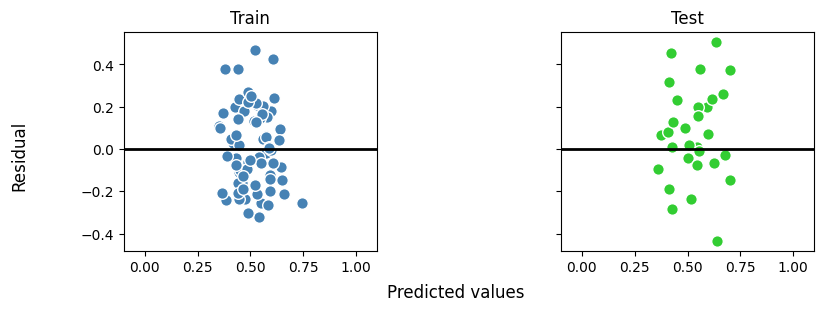

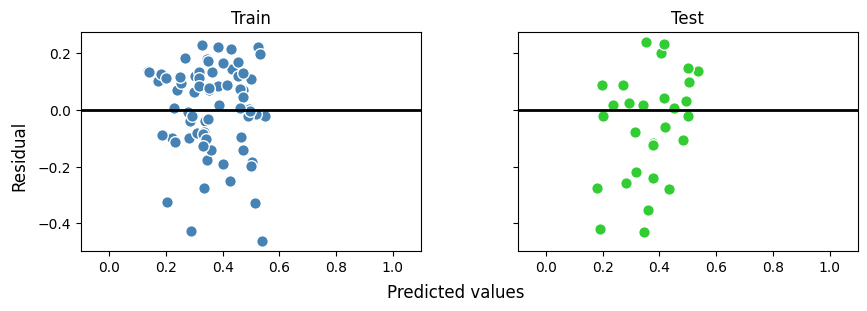

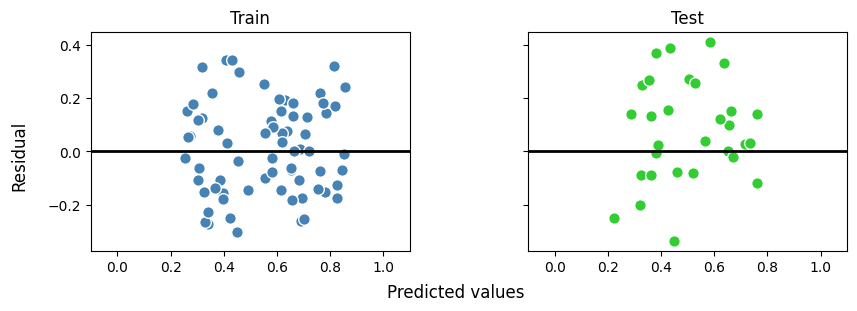

In [ ]:
resArr = []
for i in range(dfY.shape[1]):
    y_train = Y_train_std[:, i]
    y_test = Y_test_std[:, i]
    y_train_pred = Y_train_pred[:, i]
    y_test_pred = Y_test_pred[:, i]
    plot_res(y_train, y_test, y_train_pred, y_test_pred, xlim=[-0.1, 1.1])
    res = store_results(y_train, y_test, y_train_pred, y_test_pred)
    resArr.append(res)

dfRes = pd.DataFrame.from_dict(resArr)
dfRes

In [ ]:
att = attn_train.detach().numpy()
print(att.shape)

(70, 301, 4, 301)


In [ ]:

att = attn_train.detach().numpy()
dataArr = []
for sample in range(0, att.shape[0]):
    for head in range(0, att.shape[2]):
        data = att[sample, :, head, :] 
        dataArr.append(data[-1,:]) # Can choose -2 or -3 for specific output

df = pd.DataFrame(data)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,0.002751,0.003032,0.003225,0.003352,0.003428,0.003469,0.003491,0.003502,0.003509,0.003513,...,0.002880,0.002880,0.002880,0.002880,0.002880,0.002880,0.002880,0.000877,0.000949,0.001078
1,0.002878,0.003125,0.003283,0.003382,0.003438,0.003465,0.003476,0.003480,0.003480,0.003479,...,0.003020,0.003020,0.003020,0.003020,0.003020,0.003020,0.003020,0.000839,0.000870,0.000954
2,0.002998,0.003205,0.003327,0.003402,0.003440,0.003457,0.003461,0.003459,0.003455,0.003451,...,0.003120,0.003120,0.003120,0.003120,0.003120,0.003120,0.003120,0.000858,0.000858,0.000911
3,0.003098,0.003268,0.003361,0.003414,0.003440,0.003448,0.003447,0.003442,0.003436,0.003430,...,0.003189,0.003189,0.003189,0.003189,0.003189,0.003189,0.003189,0.000896,0.000870,0.000899
4,0.003175,0.003316,0.003384,0.003422,0.003438,0.003440,0.003436,0.003429,0.003422,0.003415,...,0.003238,0.003238,0.003238,0.003238,0.003238,0.003238,0.003238,0.000933,0.000886,0.000896


Text(0, 0.5, 'Attention Score')

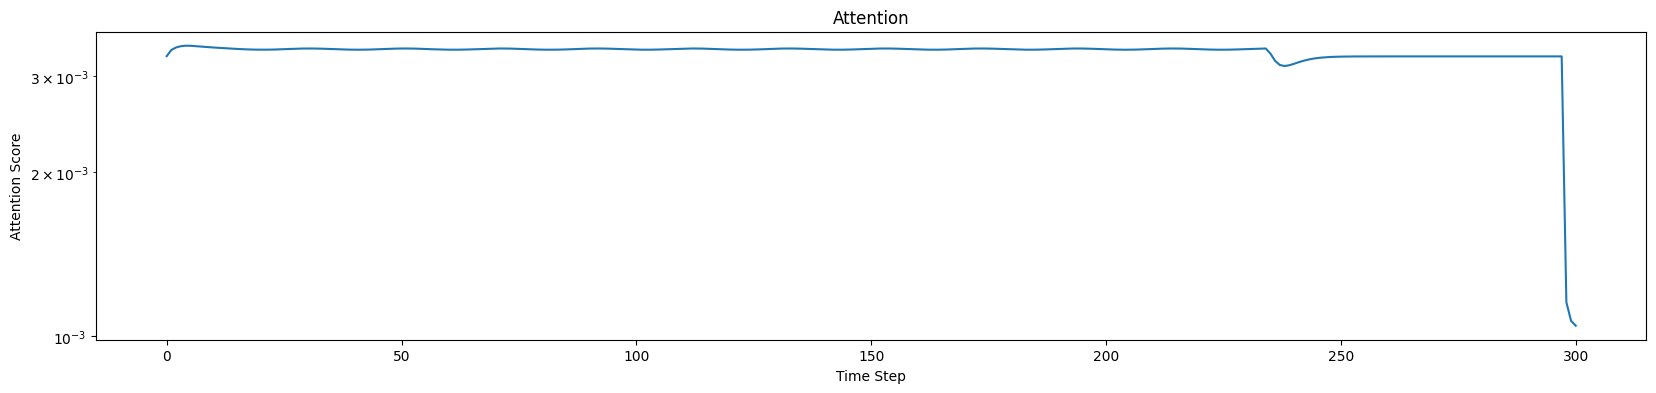

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,4))
df.mean(axis=0).plot(logy=True, ax=ax)
ax.set_title("Attention")
ax.set_xlabel("Time Step")
ax.set_ylabel("Attention Score")